# C14-hepatocyte analysis

default_parameters -> fit

default_limit -> physical

parameters -> physical

In [1]:
import datetime
from IPython.display import display
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import warnings

%matplotlib inline

mem = joblib.Memory(location='~/tmp/hepato/', verbose=0)

import logging

%load_ext rpy2.ipython

# logging.basicConfig(filename='c14.log',
#                              filemode='a',
#                              format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
#                             datefmt='%H:%M:%S',
#                              level=logging.DEBUG)
logging.basicConfig(level=logging.WARNING)

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

In [3]:
# %load_ext autoreload
# %autoreload 2
import c14
import c14.models.liver
import c14.models.minimal

## Data

In [6]:
data = pd.read_csv('../data/C14data_liver_samples_20191023.csv')
data = data.groupby(['type', 'sample', 'ploidy', 'pathology']).mean().dropna(how='all').reset_index()
data['Dbirth'] -= 0.5
data['age'] = data['Dcoll'] - data['Dbirth']
data = data.query('type == "hepatocyte" and pathology != "Y"')
edata = c14.exp_data(data)

## Fit the models

In [7]:
@mem.cache
def fit_model(edata, model, step_size=0.1, optimize_minuit_multistart_kwargs=dict(n=100,processes=8)):
    print(f'Fitting model {model.__name__}')
    result = {'model': model()}
    result['op'] = c14.optimize(model=result['model'].copy(),data=edata,step_size=step_size)
    result['vis'] = c14.visualisze(model=result['model'].copy(),data=edata,step_size=step_size)
    result['multistart_result'] = result['op'].optimize_minuit_multistart(**optimize_minuit_multistart_kwargs)
    try:
        result['point_estimate'] = result['multistart_result'].sort_values('fval').iloc[0]['values']
        result['cov'] = result['multistart_result'].sort_values('fval').iloc[0]['cov']
    except:
        print(f'Multistart found no valid results for model {model.__name__}')
    try:
        result['errors'] = result['vis'].calc_error(result['point_estimate'], result['cov'], ignore_physics=True)
    except:
        print(f'Could not calculate errors for {model.__name__}')
    return result

In [8]:
def fit_models(edata, models, step_size=0.1, optimize_minuit_multistart_kwargs=dict(n=100,processes=8)):
    results = {model.__name__: fit_model(edata, model, step_size, optimize_minuit_multistart_kwargs)
               for model in models}
    return results

In [9]:
models = c14.models.liver.models_list + [c14.models.minimal.POP1]
# models = [c14.models.liver.R]
models

[c14.models.liver.D,
 c14.models.liver.K,
 c14.models.liver.L,
 c14.models.liver.R,
 c14.models.liver.R2K24,
 c14.models.liver.Dk24lin,
 c14.models.liver.Dr2lin,
 c14.models.minimal.POP1]

In [10]:
init_limit = {'r2': (-3, 0), 
              'r2_0': (-3, 0), 
              'r2_100': (-3, 0), 
              'r4': (-3, 0),
              'lambda2': (-3, 0),
              'lambda4': (-3, 0),
              'kappa24': (-3, 0),
              'kappa24_0': (-3, 0),
              'kappa24_100': (-3, 0),
              'kappa42': (-3, 0),
              'delta2': (-3, 0),
              'delta2_0': (-3, 0),
              'delta2_100': (-3, 0),
              'delta4': (-3, 0),
              'f': (1, 3),
              'lambda_': (-3, 0),
              'r2_0': (-3, 0),
              'r2_1': (-3, 0),
              'r2_100': (-3, 0),
              't_step': (np.log10(5), np.log10(70))
             }

In [11]:
np.seterr(all='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [16]:
%%time
results = fit_models(edata, models, step_size=2, 
                     optimize_minuit_multistart_kwargs=dict(n=100, 
                                                            processes=12, 
                                                            init_limit=init_limit)
                    )

Fitting model D
[(-3, 0), (-3, 0), (-3, 0), (-3, 0)]
Fitting model K
[(-3, 0), (-3, 0), (-3, 0), (-3, 0)]
Multistart found no valid results for model K
Could not calculate errors for K
Fitting model L
[(-3, 0), (-3, 0), (-3, 0), (-3, 0)]
Multistart found no valid results for model L
Could not calculate errors for L
Fitting model R
[(-3, 0), (-3, 0), (-3, 0), (-3, 0)]
Fitting model R2K24
[(-3, 0), (-3, 0), (-3, 0), (-3, 0)]
Fitting model Dk24lin
[(-3, 0), (-3, 0), (-3, 0), (-3, 0), (-3, 0)]
Fitting model Dr2lin
[(-3, 0), (-3, 0), (-3, 0), (-3, 0), (-3, 0)]
Fitting model POP1
[(-3, 0)]
CPU times: user 10 s, sys: 670 ms, total: 10.7 s
Wall time: 5min 23s


In [21]:
def summarise(results):
    parameters = pd.concat(
        [result['vis'].get_parameter(result['point_estimate'], 
                                     result['cov'], 
                                     t_eval=[20, 50, 80],
                                     samples=1000,
                                    ignore_physics=True)
         .assign(model = name).reset_index() for name, result in results.items()
        ], ignore_index=True)

    parameters['point_estimate'] = parameters['point_estimate'].astype(float)
    parameters['lower'] = parameters['lower'].astype(float)
    parameters['upper'] = parameters['upper'].astype(float).replace(np.inf, 1e99)
    parameters['parameter'] = parameters['parameter'].astype(str)
    parameters['time'] = parameters['time'].astype(str)

    parameters['ymin'] = parameters['point_estimate'] - parameters['lower']
    parameters['ymax'] = parameters['upper'] - parameters['point_estimate']
    return parameters

In [22]:
parameters = summarise(results)
# parameters_young = summarise(results_young)
# parameters_old = summarise(results_old)

In [23]:
parameters[parameters['lower'] > parameters['point_estimate']]

,time,parameter,point_estimate,lower,upper,model,ymin,ymax
51,20,p4,0.545074,0.563132,1.039676,R,-0.018058,0.494602


In [24]:
parameters[(parameters['upper'] < parameters['point_estimate'])]

,time,parameter,point_estimate,lower,upper,model,ymin,ymax
105,50,p2,0.993055,-0.626722,0.987031,R2K24,1.619777,-0.006024
117,80,p2,0.997303,-0.884002,0.952095,R2K24,1.881305,-0.045208
121,80,ratio_kappa,16.099200,-0.003846,3.378630,R2K24,16.103046,-12.720571


## Parameter Values

### Summarized

In [29]:
parameters.query('parameter == "delta2" and time == "20"')

,time,parameter,point_estimate,lower,upper,model,ymin,ymax
0,20,delta2,0.359663,2.402987e-01,0.547027,D,1.193642e-01,0.187364
42,20,delta2,0.396191,2.450971e-01,0.626663,R,1.510936e-01,0.230472
87,20,delta2,0.346134,2.412208e-01,0.495582,R2K24,1.049133e-01,0.149448
123,20,delta2,0.378252,-2.708588e+07,0.597992,Dk24lin,2.708588e+07,0.219740
165,20,delta2,0.372726,2.374096e-01,0.681745,Dr2lin,1.353165e-01,0.309019


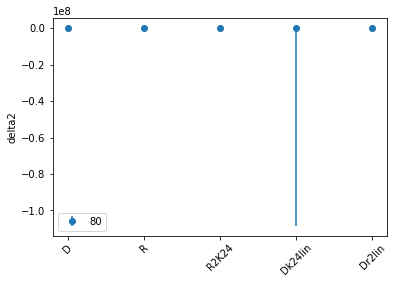

In [32]:
fig, ax = plt.subplots()
data = parameters[parameters['parameter'] == 'delta2']

ax.errorbar('model', 'point_estimate', time_data[['ymin', 'ymax']].T.abs().values,
            data=time_data, marker='o', ls='None', label=time)
ax.legend()
ax.set_ylabel(parameter)
#     try:
#         ax.set_ylim(ylimits[parameter])
#     except:
# ylim = ax.get_ylim()
# ax.set_ylim(max(ylim[0], 0), ylim[1])
ax.tick_params(axis='x', labelrotation=45)

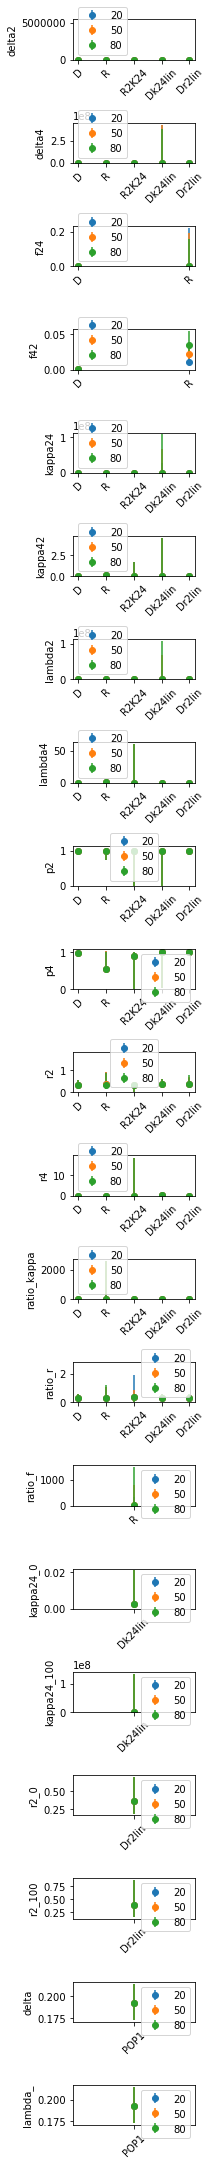

In [34]:
p_names = parameters['parameter'].unique()
# paras = [parameters, parameters_young, parameters_old]

fig, axs = plt.subplots(len(p_names), 1, figsize=(3, 30))



ylimits = {'delta2': (0, 1),
           'p2': (0.5, 1.1),
           'p4': (0.5, 1.1),
           'kappa24': (0, 0.5),
           'kappa42': (0, 1.15),
          'ratio_kappa': (0, 10)}

for parameter, ax in zip(p_names, axs):
    data = parameters[parameters['parameter'] == parameter]
    for time, time_data in data.groupby('time'):
        ax.errorbar('model', 'point_estimate', time_data[['ymin', 'ymax']].T.abs().values,
                    data=time_data, marker='o', ls='None', label=time)
        ax.legend()
        ax.set_ylabel(parameter)
#     try:
#         ax.set_ylim(ylimits[parameter])
#     except:
    ylim = ax.get_ylim()
    ax.set_ylim(max(ylim[0], 0), ylim[1])
    ax.tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()

### Detailed

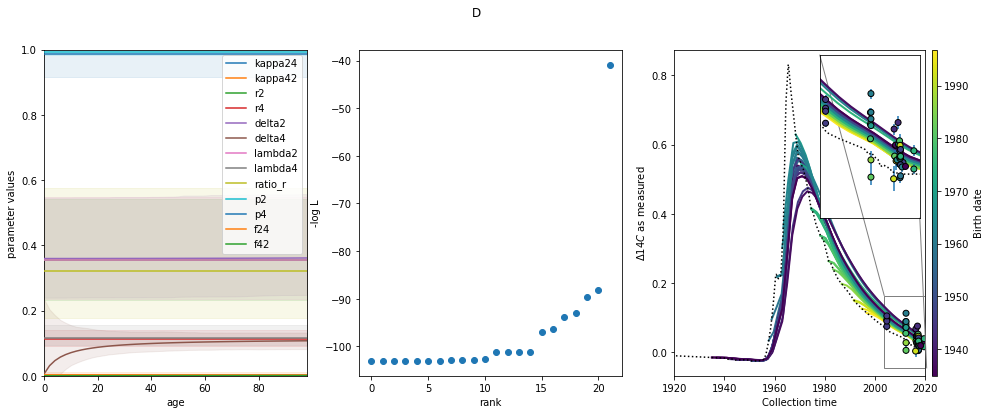

point_estimate        lower        upper
time parameter                                           
0    delta2            0.359501     0.239465     0.546673
     delta4          0.00631967    -0.089529     0.234405
     f24             0.00255547    0.0011256   0.00610865
     f42            3.94922e-05  4.38869e-06  0.000318364
     kappa24         0.00263068   0.00115873   0.00628844
     kappa42         0.00138133  0.000153504    0.0111355
     lambda2           0.356342     0.236512     0.548533
     lambda4           0.115037    0.0942441     0.155545
     p2                0.992618     0.983128     0.996666
     p4                0.987992     0.916029     0.998679
     r2                0.353711      0.23365      0.54253
     r4                0.113656    0.0906127     0.141804
     ratio_kappa       0.525085    0.0455817       4.8235
     ratio_r           0.321324     0.175794     0.576442
50   delta2            0.360046     0.242134     0.550336
     delta4              0.1018    0.0780886     0.134643
     f24             0.00200447  0.000882904   0.00479154
     f42            0.000328812  3.65402e-05    0.0026507
     kappa24         0.00263068   0.00115873   0.00628844
     kappa42         0.00138133  0.000153504    0.0111355
     lambda2           0.356342     0.236512     0.548533
     lambda4           0.115037    0.0942441     0.155545
     p2                0.992618     0.983128     0.996666
     p4                0.987992     0.916029     0.998679
     r2                0.353711      0.23365      0.54253
     r4                0.113656    0.0906127     0.141804
     ratio_kappa       0.525085    0.0455817       4.8235
     ratio_r           0.321324     0.175794     0.576442
80   delta2            0.360683      0.24575     0.555946
     delta4             0.10606    0.0811317     0.132492
     f24             0.00167387  0.000737286   0.00400127
     f42            0.000502403   5.5831e-05    0.0040501
     kappa24         0.00263068   0.00115873   0.00628844
     kappa42         0.00138133  0.000153504    0.0111355
     lambda2           0.356342     0.236512     0.548533
     lambda4           0.115037    0.0942441     0.155545
     p2                0.992618     0.983128     0.996666
     p4                0.987992     0.916029     0.998679
     r2                0.353711      0.23365      0.54253
     r4                0.113656    0.0906127     0.141804
     ratio_kappa       0.525085    0.0455817       4.8235
     ratio_r           0.321324     0.175794     0.576442
100  delta2            0.361336      0.24792     0.557473
     delta4            0.107489    0.0820007     0.132324
     f24             0.00145348  0.000640208   0.00347442
     f42            0.000618131  6.86916e-05   0.00498303
     kappa24         0.00263068   0.00115873   0.00628844
     kappa42         0.00138133  0.000153504    0.0111355
     lambda2           0.356342     0.236512     0.548533
     lambda4           0.115037    0.0942441     0.155545
     p2                0.992618     0.983128     0.996666
     p4                0.987992     0.916029     0.998679
     r2                0.353711      0.23365      0.54253
     r4                0.113656    0.0906127     0.141804
     ratio_kappa       0.525085    0.0455817       4.8235
     ratio_r           0.321324     0.175794     0.576442

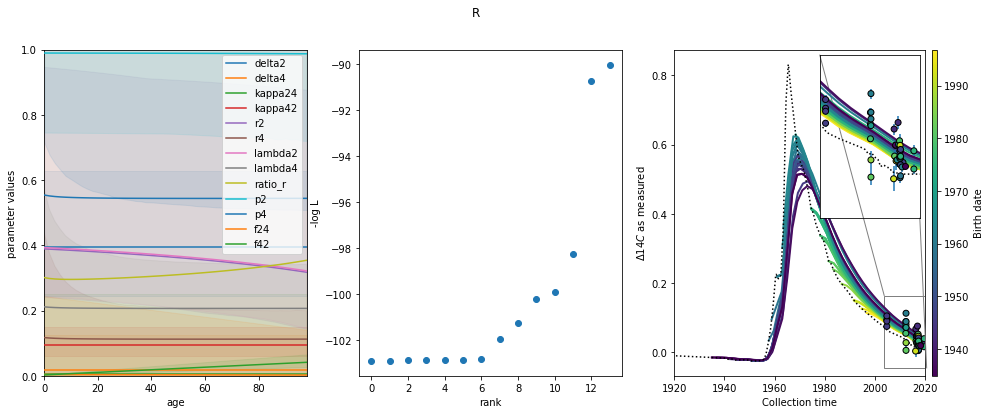

point_estimate        lower       upper
time parameter                                          
0    delta2            0.396191     0.245097    0.626663
     delta4           0.0170881   0.00215999    0.123653
     f24             0.00398636  4.97043e-05    0.244301
     f42             0.00269387   0.00175333  0.00427338
     kappa24         0.00410368  5.11671e-05    0.251491
     kappa42          0.0942243    0.0613266    0.149471
     lambda2           0.393245     0.243482     1.20297
     lambda4           0.211394     -16.5173    0.571552
     p2                0.989565     0.745812    0.999835
     p4                0.554272     0.716052     1.02289
     r2                0.389141     0.241569    0.947063
     r4                 0.11717     -16.5486    0.439393
     ratio_f           0.675773   0.00905126     76.6906
     ratio_kappa        22.9609     0.307537     2605.74
     ratio_r           0.301098     -22.1892     1.73046
50   delta2            0.396191     0.245097    0.626663
     delta4           0.0170881   0.00215999    0.123653
     f24             0.00312684  3.89873e-05    0.191626
     f42              0.0224292    0.0145982   0.0355801
     kappa24         0.00410368  5.11671e-05    0.251491
     kappa42          0.0942243    0.0613266    0.149471
     lambda2           0.366428     0.208127     1.17564
     lambda4           0.206582     -1.19738    0.348391
     p2                0.988801     0.741514    0.999801
     p4                0.543888     0.525446      1.0363
     r2                0.362325     0.205679    0.907084
     r4                0.112357     -1.30386     0.20549
     ratio_f             7.1731    0.0960761     814.045
     ratio_kappa        22.9609     0.307537     2605.74
     ratio_r           0.310101     -1.78951      1.0532
80   delta2            0.396191     0.245097    0.626663
     delta4           0.0170881   0.00215999    0.123653
     f24             0.00261113  3.25571e-05    0.160021
     f42              0.0342703    0.0223051   0.0543641
     kappa24         0.00410368  5.11671e-05    0.251491
     kappa42          0.0942243    0.0613266    0.149471
     lambda2           0.341725     0.177611     1.14243
     lambda4           0.206597    -0.527997    0.341483
     p2                0.987991     0.732179    0.999774
     p4                0.543922     0.512237     1.01809
     r2                0.337621      0.17443    0.890034
     r4                0.112373    -0.595793    0.200073
     ratio_f            13.1247     0.175791     1489.47
     ratio_kappa        22.9609     0.307537     2605.74
     ratio_r           0.332837    -0.917985     1.22875
100  delta2            0.396191     0.245097    0.626663
     delta4           0.0170881   0.00215999    0.123653
     f24             0.00226733  2.82704e-05    0.138951
     f42              0.0421644     0.027443   0.0668868
     kappa24         0.00410368  5.11671e-05    0.251491
     kappa42          0.0942243    0.0613266    0.149471
     lambda2           0.318947     0.143398     1.12737
     lambda4           0.206685     -0.28657    0.341744
     p2                0.987134     0.718259    0.999778
     p4                0.544116     0.507987     1.00963
     r2                0.314843     0.141339    0.875345
     r4                 0.11246    -0.349057    0.199349
     ratio_f            18.5965     0.249081     2110.44
     ratio_kappa        22.9609     0.307537     2605.74
     ratio_r           0.357195    -0.833377     1.35006

ImplicitParametersOutOfRange: kappa24 is small

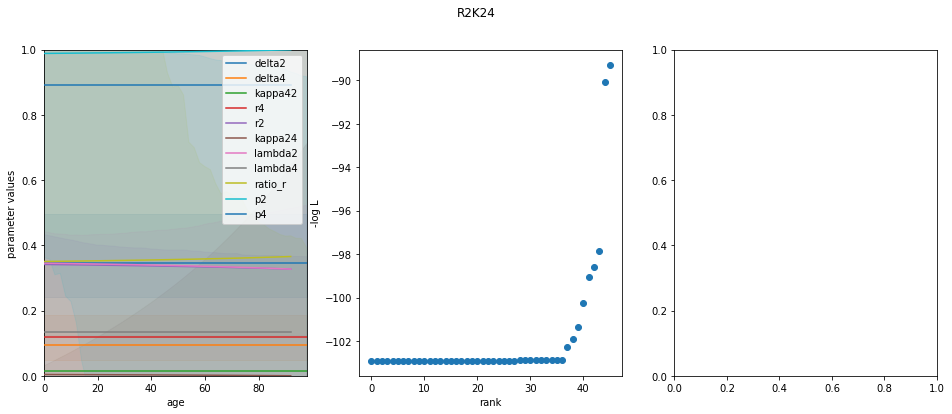

In [35]:
for name, result in results.items():
    if name not in ['']:
        no_plot = ['ratio_kappa', 'ratio_f']
        fig, axs = plt.subplots(1, 3, figsize=(16,6))
        fig.suptitle(name)
        result['vis'].plot_parameter(result['point_estimate'], result['errors'],
                                         no_plot=no_plot, axis=axs[0])
#         result['vis'].plot_parameter(result['point_estimate'], 
#                                          no_plot=no_plot, axis=axs[0])

        axs[0].legend()
        axs[0].set_ylabel('parameter values')
        axs[0].set_ylim(0, 1)

        fval = result['multistart_result']['fval']
        axs[1].scatter(np.arange(len(fval)), fval.values)
        axs[1].set_xlabel('rank')
        axs[1].set_ylabel('-log L')
    #         axs[1].set_xlim(0, 100)
        
        _ = result['vis'].odeint()
        result['vis'].plot_simdata( axis=axs[2], cmap=plt.cm.viridis)
        axs[2].set_xlim(1920, 2020)

        plt.show()

        try:
            display(result['vis'].get_parameter(result['point_estimate'], result['cov'], t_eval=[0, 50, 80, 100], ignore_physics=True
                                               ))
        except:
            pass

## Export

In [ ]:
# model = 'A'

# time = np.linspace(0, 100, 101)
# df = pd.DataFrame(results[model]['model'].get_implicit_parameters(time))[['r2', 'kappa24', 'ratio_r', 'p']]
# # df.columns=['r2', 'r4', 'kappa24', 'kappa42', 'ratio_r']
# df['r4'] = results[model]['model'].r4
# df['kappa42'] = results[model]['model'].kappa42
# df['delta2'] = results[model]['model'].delta2
# df['delta4'] = results[model]['model'].delta4
# df['age'] = time
# df['ploidy'] = c14.models.liver.A().ploidy(df['age'])
# df.head()

# result = results[model]
# df = result['vis'].get_parameter(result['point_estimate'], result['cov'], t_eval=time).unstack().reset_index()

# df = df[['time', 'point_estimate']]

# df.to_excel('../../../results/parameters_A.xlsx')

## Model selection

In [36]:
# _ = results.pop('POP1', None)

In [37]:
model_selection_results = pd.DataFrame(
    pd.Series(
        {name: result['op'].calc_aicc(result['point_estimate'])
         for name, result in results.items()}, name='cAIC'))
model_selection_results['loglike'] = [result['op'].loglike_dict(result['point_estimate']) for name, result in results.items()]
model_selection_results['nparas'] = [result['model'].nparas for name, result in results.items()] 
model_selection_results['nparas'] += 1
model_selection_results = pd.DataFrame(model_selection_results)
model_selection_results['delta'] = model_selection_results['cAIC'] - model_selection_results['cAIC'].min() 
model_selection_results['w'] = np.exp(-0.5*model_selection_results['delta']) / np.exp(-0.5*model_selection_results['delta']).sum()
model_selection_results['ER'] = model_selection_results['w'].max() / model_selection_results['w']
model_selection_results.sort_values('cAIC')

,cAIC,loglike,nparas,delta,w,ER
POP1,-197.508246,100.912018,2,0.000000,0.595902,1.000000
D,-194.389359,103.051822,5,3.118888,0.125290,4.756175
R2K24,-194.112007,102.913147,5,3.396239,0.109066,5.463663
R,-194.058065,102.886176,5,3.450181,0.106164,5.613029
Dk24lin,-191.682318,103.076453,6,5.825928,0.032366,18.411292
Dr2lin,-191.609701,103.040144,6,5.898546,0.031212,19.092067


In [ ]:
# parameters = parameters.merge(model_selection_results, left_on='model', right_index=True)

In [ ]:
# parameters['log10_point_estimate'] = np.log10(parameters['point_estimate'])
# parameters['log10_lower'] = np.log10(parameters['lower'])
# parameters['log10_upper'] = np.log10(parameters['upper'])
# parameters.head()

# parameters['log10_error_lower'] = parameters['log10_point_estimate'] - parameters['log10_lower']
# parameters['log10_error_upper'] = -parameters['log10_point_estimate'] + parameters['log10_upper']

# parameters['log10_error'] = parameters[['log10_error_lower', 'log10_error_upper']].mean(axis='columns')

# parameters.head()

# def parameter_average(data):
#     parameter = data['parameter'].iloc[0]
#     log10_mean = np.average(data['log10_point_estimate'], weights=data['w'])
#     log10_error = np.average(
#         np.sqrt(data['log10_error']**2 + (data['log10_point_estimate'] - log10_mean)**2),
#         weights=data['w'])
#     point_estimate = 10**log10_mean
#     lower = 10**(log10_mean-log10_error)
#     upper = 10**(log10_mean+log10_error)
#     return pd.Series({
#         'point_estimate': point_estimate,
#         'lower': lower,
#         'upper': upper,
#         'model': 'average',
#         'ymin': point_estimate - lower,
#         'ymax': point_estimate + upper,
#         'log10_point_estimate': log10_mean,
#         'log10_error': log10_error
#     })

# rates = ["r2", "r4", "delta2", "delta4", "kappa24", "kappa42", "lambda2", "lambda4"]

# averaged_parameters = (parameters
#                        .query('parameter in @rates')
#                        .groupby(['time', 'parameter'])
#                        .apply(parameter_average)
#                        .reset_index()
#                         )

In [ ]:
# parameters = pd.concat([parameters, averaged_parameters], axis='rows', sort=False)

In [ ]:
# p_names = parameters['parameter'].unique()
# paras = 3*[parameters]
# fig, axss = plt.subplots(len(p_names), len(paras), figsize=(9, 30))



# ylimits = {'delta2': (0, 2),
#            'delta4': (0, 1),
#            'lambda2': (0, 2),
#            'r2': (0, 2),
#            'p2': (0.5, 1.1),
#            'p4': (0.5, 1.1),
#            'kappa24': (0, 0.2),
#           'ratio_kappa': (0, 10)}

# for parameter, axs in zip(p_names, axss):
#     for para, ax in zip(paras, axs):
#         data = para[para['parameter'] == parameter]
#         for time, time_data in data.groupby('time'):
#             ax.errorbar('model', 'point_estimate', time_data[['ymin', 'ymax']].T.abs().values,
#                         data=time_data, marker='o', ls='None', label=time)
#             ax.legend()
#             ax.set_ylabel(parameter)
#         try:
#             ax.set_ylim(ylimits[parameter])
#         except:
#             ax.set_ylim(0, 1)
#         ax.tick_params(axis='x', labelrotation=45)

# plt.tight_layout()
# plt.show()